# MRMC Basic Results

In [158]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '../../..'))

%load_ext autoreload
%autoreload 2

import numba
import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn import model_selection

import matplotlib.pyplot as plt
import seaborn as sns
from models import model_interface, model_loader, model_constants
from data import data_loader
from data.adapters import continuous_adapter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preliminaries -- load everything

In [4]:
DATASET, DATASET_INFO = data_loader.load_data(data_loader.DatasetName('credit_card_default'))
MODEL = model_loader.load_model(model_constants.ModelType('logistic_regression'), data_loader.DatasetName('credit_card_default'))
ADAPTER = continuous_adapter.StandardizingAdapter(
    label_column = DATASET_INFO.label_column, positive_label=DATASET_INFO.positive_label
).fit(DATASET)

results_dir = '../../../experiment_results/mrmc_results/mrmc_comparison'

cluster_df = pd.read_csv(os.path.join(results_dir, 'cluster_df.csv'))
index_df = pd.read_csv(os.path.join(results_dir, 'experiment_config_df.csv'))
path_df = pd.read_csv(os.path.join(results_dir, 'mrmc_paths_df.csv'))
index_df

/home/jakeval/umass/research/.venv/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jakeval/umass/research/.venv/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,batch_id,run_id,run_seed,cluster_seed,confidence_cutoff,dataset_name,max_iterations,model_type,noise_ratio,num_clusters,rescale_ratio,step_size,volcano_cutoff,volcano_degree
0,2,65,8286,1834823,0.6,credit_card_default,30,logistic_regression,NaN,4,NaN,1,0.5,2
1,9,275,8286,1834823,0.8,credit_card_default,30,logistic_regression,NaN,3,NaN,1,0.5,2
2,2,83,211,1834823,0.6,credit_card_default,30,logistic_regression,NaN,4,NaN,1,0.5,2
3,12,374,51,1834823,0.9,credit_card_default,30,logistic_regression,NaN,2,NaN,1,0.5,2
4,3,114,3069,1834823,0.6,credit_card_default,30,logistic_regression,NaN,5,NaN,1,0.5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,14,429,1498,1834823,0.9,credit_card_default,30,logistic_regression,NaN,4,NaN,1,0.5,2
476,6,196,5500,1834823,0.7,credit_card_default,30,logistic_regression,NaN,4,NaN,1,0.5,2
477,2,71,7699,1834823,0.6,credit_card_default,30,logistic_regression,NaN,4,NaN,1,0.5,2
478,3,97,5653,1834823,0.6,credit_card_default,30,logistic_regression,NaN,5,NaN,1,0.5,2


## Fit a KDE

In [6]:
kfold = model_selection.KFold(n_splits=5)
transformed_data = ADAPTER.transform(DATASET.drop(columns='Y')).sample(frac=1, replace=False)

bandwidths = np.logspace(-1, 0, 6)
scores = []

for bw in bandwidths:
    print("Evaluate bandwidth", bw)
    score = 0
    for train_indices, val_indices in kfold.split(transformed_data):
        kde = neighbors.KernelDensity(bandwidth=bw).fit(transformed_data.iloc[train_indices])
        score += kde.score(transformed_data.iloc[val_indices])
    scores.append(score / len(bandwidths))
    print(scores[-1])
best_bandwidth = bandwidths[np.argmax(scores)]
print("Finished! Selected bandwidth is ", best_bandwidth)
KDE = neighbors.KernelDensity(bandwidth=bw).fit(transformed_data)
print("Scoring full dataset...")
scores = KDE.score_samples(transformed_data)

Evaluate bandwidth 0.1


KeyboardInterrupt: 

### Evaluate the KDE qualitatively

The scores are between -28 and -20. Unsurprisingly, most points have relatively high density.
Overall the histogram seems reasonable.

,density
count,30000.000000
mean,0.757195
std,1.807533
min,-1.056702
25%,-1.006593
50%,0.176263
75%,2.377158
max,4.556161


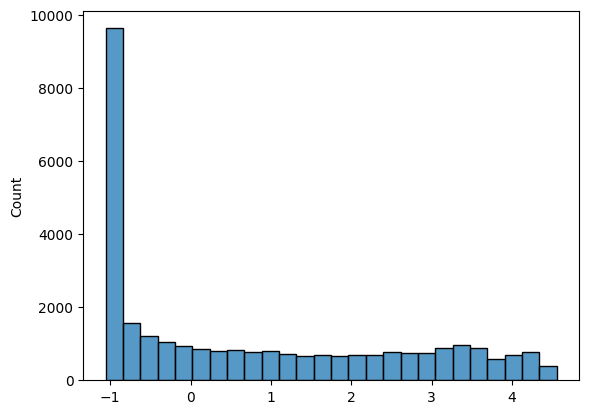

In [7]:
#best_bandwidth = bandwidths[np.argmax(scores)]
transformed_data = ADAPTER.transform(DATASET.drop(columns='Y')).sample(frac=1, replace=False)
best_bandwidth = 0.251188643150958
KDE = neighbors.KernelDensity(bandwidth=best_bandwidth).fit(transformed_data)
KDE_SCORES = KDE.score_samples(transformed_data)
sns.histplot(KDE_SCORES)
pd.DataFrame({'density': KDE_SCORES}).describe()

# Analyze the results

In [155]:
# Generate some numpy arrays so we can pass of to numba
# The slowest here will be KDE

# order the paths dataframe
ordered_paths = path_df.sort_values(['run_id', 'path_id', 'step_id'])
run_ids = ordered_paths.run_id.to_numpy()
path_ids = ordered_paths.path_id.to_numpy()

# get the raw data -- we've already extracted the run_id and path_id.
paths = ordered_paths.drop(columns=['run_id', 'batch_id', 'step_id', 'path_id'])

# pos_proba and target_proba are calculated for every point in every path
pos_proba = MODEL.predict_pos_proba(paths).to_numpy()
target_proba = ordered_paths.merge(index_df[['run_id', 'confidence_cutoff']], how='left', on='run_id', validate='many_to_one').confidence_cutoff.to_numpy()

numpy_paths = ADAPTER.transform(paths).to_numpy()

# the first path begins at boundary_indices[0]. The second path begins at boundary_indices[1]. There is no path beginning at boundary_indices[-1].
boundary_indices = np.arange(run_ids.shape[0])[(path_ids != np.hstack([[-1], path_ids[:-1]]))]
boundary_indices = np.hstack([boundary_indices, path_ids.shape[0]])

# run KDE over the POIs and CFEs
pois = paths.iloc[boundary_indices[:-1]]
counterfactuals = paths.iloc[boundary_indices[1:] - 1]
poi_kde = KDE.score_samples(ADAPTER.transform(pois))
cfe_kde = KDE.score_samples(ADAPTER.transform(counterfactuals))

In [156]:
@numba.jit(nopython=True)
def get_sparsity(path: np.ndarray) -> int:
    if path.shape[0] == 1:
        return np.nan
    path_sparsity = np.zeros(path.shape[0])
    for i in range(1, path.shape[0]):
        path_sparsity[i] = ((path[i] - path[i - 1]) != 0).sum()
    return np.max(path_sparsity)

@numba.jit(nopython=True)
def get_path_length(path: np.ndarray) -> float:
    total = 0
    for i in range(1, path.shape[0]):
        total += np.linalg.norm(path[i] - path[i - 1])
    if total == 0:
        return np.nan
    return total

@numba.jit(nopython=True)
def analyze_paths(
    paths: np.ndarray,
    run_ids: np.ndarray,
    path_ids: np.ndarray,
    pos_proba: np.ndarray,
    target_proba: np.ndarray,
    boundary_indices: np.ndarray,
    poi_kde: np.ndarray,
    cfe_kde: np.ndarray
):
    columns = ['run_id', 'path_id', 'success', 'path_length', 'poi_density', 'cfe_density', 'sparsity']
    col_idx = {}
    for i, col in enumerate(columns):
        col_idx[col] = i
    results = np.zeros((len(boundary_indices) - 1, len(columns)))
    for i in range(boundary_indices.shape[0]-1):
        start_idx, end_idx = boundary_indices[i:i+2]
        path = paths[start_idx:end_idx]
        results[i,col_idx['run_id']] = run_ids[start_idx]
        results[i,col_idx['path_id']] = path_ids[start_idx]
        results[i,col_idx['success']] = 1 if pos_proba[end_idx - 1] >= target_proba[end_idx - 1] else 0
        results[i,col_idx['path_length']] = get_path_length(path)
        results[i,col_idx['poi_density']] = poi_kde[i]
        results[i,col_idx['cfe_density']] = cfe_kde[i]
        results[i,col_idx['sparsity']] = get_sparsity(path)

    return results, columns

In [162]:
numpy_results, columns = analyze_paths(numpy_paths, run_ids, path_ids, pos_proba, target_proba, boundary_indices, poi_kde, cfe_kde)

results = pd.DataFrame(data=numpy_results, columns=columns).merge(index_df, how='left', on='run_id').drop(columns=['dataset_name', 'max_iterations', 'model_type', 'noise_ratio', 'rescale_ratio', 'step_size', 'cluster_seed', 'volcano_cutoff', 'volcano_degree', 'run_seed'])
results

,run_id,path_id,success,path_length,poi_density,cfe_density,sparsity,batch_id,confidence_cutoff,num_clusters
0,0.0,0.0,1.0,7.0,-1.056702,-5.075051,20.0,0,0.6,2
1,0.0,1.0,1.0,7.0,-1.056702,-10.405564,20.0,0,0.6,2
2,1.0,0.0,1.0,4.0,-0.133078,-4.471909,20.0,0,0.6,2
3,1.0,1.0,1.0,5.0,-0.133078,-7.113181,20.0,0,0.6,2
4,2.0,0.0,1.0,2.0,2.621801,0.865961,20.0,0,0.6,2
...,...,...,...,...,...,...,...,...,...,...
1675,479.0,0.0,1.0,12.0,-1.055231,-35.423054,17.0,15,0.9,5
1676,479.0,1.0,1.0,10.0,-1.055231,-26.209792,19.0,15,0.9,5
1677,479.0,2.0,1.0,14.0,-1.055231,-72.536744,17.0,15,0.9,5
1678,479.0,3.0,1.0,17.0,-1.055231,-221.736091,17.0,15,0.9,5


# Let's look at the average metrics across the full batch


In [165]:
results.groupby('batch_id').mean().sort_values(['confidence_cutoff', 'num_clusters'])

,run_id,path_id,success,path_length,poi_density,cfe_density,sparsity,confidence_cutoff,num_clusters
batch_id,,,,,,,,,
0,14.5,0.5,1.0,4.950000,-0.169042,-2.756733,20.000000,0.6,2.0
1,44.5,1.0,1.0,4.644444,-0.169042,-11.293595,20.000000,0.6,3.0
2,74.5,1.5,1.0,5.091667,-0.169042,-10.864045,20.000000,0.6,4.0
3,104.5,2.0,1.0,5.346667,-0.169042,-32.087734,19.353333,0.6,5.0
4,134.5,0.5,1.0,6.316667,-0.169042,-2.892814,20.000000,0.7,2.0
5,164.5,1.0,1.0,7.033333,-0.169042,-44.571499,18.922222,0.7,3.0
6,194.5,1.5,1.0,6.725000,-0.169042,-39.788581,19.050000,0.7,4.0
7,224.5,2.0,1.0,6.980000,-0.169042,-35.384732,18.893333,0.7,5.0
8,254.5,0.5,1.0,8.483333,-0.169042,-100.988045,18.383333,0.8,2.0
